In [2]:
import math, time, random, sys
import numpy as np
import matplotlib.pyplot as plt

### **We want to compress N bit input data to M bit data. **

In [3]:
N = 2048 # length of input vector X
K = 30 # number of sparse elements in X
M = 300 # length of compressed data
if M < K*math.log(N/K):
  print ('Sampling is not enough')
  sys.exit()
lam = 1 # sparsity scale

### **Gradient of objective function**

In [4]:
def gradient(x, AtA, Aty):
  return AtA@x - Aty

SyntaxError: invalid syntax (<ipython-input-4-1e6a7098261f>, line 2)

### **Function for Proximal gradient method**

In [4]:
def proximalGradient(x, AtA, Aty, L, mu):
  u = x - 1/L*gradient(x, AtA, Aty)
  ui = np.nan_to_num(1/abs(u))
  return np.maximum(0, 1 - mu*ui)*u

### **Function for Accelerated proximal gradient method**

In [5]:
def accProximalGradient(x, px, t, AtA, Aty, L, mu):
  w = x + (t-1)/(t+2)*(x - px)
  return proximalGradient(w, AtA, Aty, L, mu)

### Function for Coordinate descent method

In [6]:
def coordinateDescent(mu_cd, Aty, AtA, x):
  for i in range(N):
    ui = np.nan_to_num((Aty[i]- AtA[i]@x + AtA[i][i]*x[i]) / AtA[i][i])
    x[i] = np.maximum(0, 1 - mu_cd[i]/abs(ui))*ui
  return x  

### **We generate a random vector s of length K. We pad and shuffle it to create a K-sarse vector X of length N.**

In [7]:
s = np.random.rand(K) # actual information
#s = 2*(np.random.rand(K)>0.5)-1
X = np.concatenate([s,np.zeros(N-K)])
np.random.shuffle(X)

### **Generate a sensing matrix A with random elements. The compressed data is y of length M.**

In [8]:
A = np.random.randn(M,N) # dictionary
y = A@X # compressed data

### Normalising A and y

In [9]:
y = y-np.mean(y)
mean = np.expand_dims(np.mean(A, axis = 0), axis = 0)
mean_stack = mean.copy()
for i in range(A.shape[0]-1):
    mean_stack = np.r_[mean_stack,mean]
A = A - mean_stack

### **Constants computed offline**

In [10]:
AtA = A.transpose()@A
Aty = A.transpose()@y
L = max(np.linalg.eigvalsh(AtA)) # Lipschitz constant
mu = lam/L;
mu_cd = np.zeros(N)
for i in range(N):
  mu_cd[i] = lam/sum(np.square(A[:,i]))
rtol = 1e-4 # relative tolerance
atol = 1e-6 # absolute tolerance
ix = np.random.rand(N) # intialisation of x

### **Proximal gradient iterations**

In [11]:
t = 1
err = 1 # cumalative error
error_pg = [] # vector of error values 
x = ix # random initial value
px = np.zeros(N) # some random previous value
start = time.time()

while not np.allclose(px, x, rtol, atol):
  px = x
  x = proximalGradient(px, AtA, Aty, L, mu)
  err = sum(np.square(y-A@x))
  error_pg.append(err)
  t = t + 1

end = time.time()
x_pg = x # saving it for plot
t_pg = t
print('Number of iterations: ', t)
print('Cumalative error: ', err)
print('Time elapsed: ', end - start)

Number of iterations:  6207
Cumalative error:  0.1259362813468983
Time elapsed:  43.76753902435303


### **Accelerated proximal gradient iterations**

In [12]:
t = 1
err = 1 # cumalative error
error_apg = [] # vector of error values 
x = ix # random initial value
px = np.zeros(N) # some random previous value
start = time.time()

while not np.allclose(px, x, rtol, atol):
  ppx = px
  px = x
  x = accProximalGradient(px, ppx, t, AtA, Aty, L, mu)
  err = sum(np.square(y-A@x))
  error_apg.append(err)
  t = t + 1

end = time.time()
x_apg = x # saving it for plot
t_apg = t
print('Number of iterations: ', t)
print('Cumalative error: ', err)
print('Time elapsed: ', end - start)

Number of iterations:  715
Cumalative error:  0.12527863602450395
Time elapsed:  5.248501777648926


### **Coordinate descent iterations**

In [13]:
t = 1
err = 1 # cumalative error
error_cd = [] # vector of error values 
x = ix # random initial value
px = np.zeros(N) # some random previous value
start = time.time()

while not np.allclose(px, x, rtol, atol):
  px = x.copy()
  x = coordinateDescent(mu_cd, Aty, AtA, x)
  err = sum(np.square(y-A@x))
  error_cd.append(err)
  t = t + 1

end = time.time()
x_cd = x # saving it for plot
t_cd = t
print('Number of iterations: ', t)
print('Cumalative error: ', err)
print('Time elapsed: ', end - start)

Number of iterations:  652
Cumalative error:  0.12503283854866784
Time elapsed:  71.78939819335938


### **LARS**

In [6]:
from sklearn import linear_model
lars = linear_model.Lars()
start = time.time()
lars.fit(A,y)
end = time.time()
x_lars = lars.coef_.reshape(N)
t_lars = lars.n_iter_
err = sum(np.square(y-A@x_lars))
print('Number of iterations: ', t_lars)
print('Cumalative error: ', err)
print('Time elapsed: ', end - start)

SyntaxError: invalid syntax (<ipython-input-6-7d4f89dca205>, line 8)

### **Plot of original data and recovered data**

In [5]:
plt.figure(1)
plt.subplot(511) # a 5X1 grid
plt.title('Original signal')
plt.stem(X)

plt.subplot(512)
plt.title('Proximal gradient')
plt.stem(x_pg)

plt.subplot(513)
plt.title('Accelerated proximal gradient')
plt.stem(x_apg)

plt.subplot(514)
plt.title('Coordinant Descent')
plt.stem(x_cd)

plt.subplot(515)
plt.title('LARS')
plt.stem(x_lars)

plt.tight_layout()
plt.show()

NameError: name 'X' is not defined

### **Plot of performance of different methods**

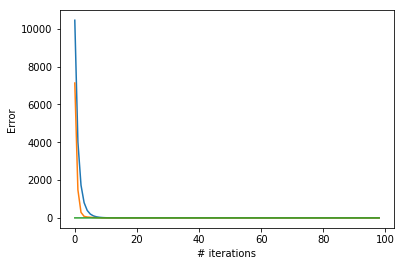

In [16]:
#min_len = math.ceil(0.1*min(len(error_pg), len(error_apg)))
min_len = 100
plt.figure(2)
plt.xlabel('# iterations')
plt.ylabel('Error')
plt.plot(error_pg[1:min_len])
plt.plot(error_apg[1:min_len])
plt.plot(error_cd[1:min_len])
plt.show()

In [17]:
with open('data.tsv', 'w') as f:
    for i in range(N):
        sent = str(i) +"\t"+ str(X[i]) +"\t"+ str(x_pg[i]) +"\t"+ str(x_apg[i]) +"\t"+ str(x_cd[i]) +"\t"+ str(x_lars[i]) +"\n" 
        f.write(sent)

In [18]:
with open('error.tsv', 'w') as f:
    for i in range(min_len):
        sent = str(i) +"\t"+ str(error_pg[i]) +"\t"+ str(error_apg[i]) +"\t"+ str(error_cd[i]) +"\n" 
        f.write(sent)